In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from app.envs.trading_env import StockTradingEnv
import gymnasium as gym

In [17]:
# Load the same ticker used for training
df = pd.read_csv("../data/processed/final_dataset.csv")

#choose one of the tickers
ticker = "AADR"  # or "AAPL", "AAON", "AAME", etc.
df = df[df["Ticker"] == ticker].reset_index(drop=True)

print(f"Evaluating trained model on {ticker}")
print("Data rows:", len(df))
print(df.head(2))

Evaluating trained model on AADR
Data rows: 1617
         Date Ticker      Close  sentiment  rsi      macd     ema_10  \
0  2014-01-02   AADR  54.709999        0.0  0.0  0.000000  54.709999   
1  2014-01-03   AADR  54.560001        0.0  0.0 -0.011966  54.682727   

      ema_30  ema_ratio  
0  54.709999   1.000000  
1  54.700322   0.999678  


In [18]:
# Initialize environment
env = StockTradingEnv(df, initial_balance=10_000)

# Load trained PPO model
model = PPO.load("../models/ppo_trading_agent")

In [19]:
real_env = env
if hasattr(env, "env"):
    real_env = env.env
if hasattr(real_env, "envs"):
    real_env = real_env.envs[0]

In [20]:
obs, _ = env.reset()
done = False

portfolio_values, actions, prices, rewards = [], [], [], []

step = 0
print(f"Starting evaluation for {ticker}...")

while not done:
    step += 1
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)

    # Record metrics
    portfolio_values.append(real_env.net_worth)
    actions.append(action)
    prices.append(real_env.df.iloc[real_env.current_step]["Close"])
    rewards.append(reward)

    # Print progress every 10 steps
    if step % 10 == 0 or done:
        print(f"Step {step:4d} | Action: {action} | Reward: {reward:8.2f} | "
              f"Net Worth: {real_env.net_worth:10.2f}")

print("\n Evaluation complete.")
print(f"Final Net Worth: ${real_env.net_worth:,.2f}")

Starting evaluation for AADR...
Step   10 | Action: 0 | Reward:   -25.48 | Net Worth:   10525.98
Step   20 | Action: 0 | Reward:  1374.10 | Net Worth:   11159.34
Step   30 | Action: 1 | Reward:   518.40 | Net Worth:   12127.28
Step   40 | Action: 0 | Reward:   -86.40 | Net Worth:   12330.68
Step   50 | Action: 2 | Reward:  -209.79 | Net Worth:   12850.98
Step   60 | Action: 1 | Reward:  -176.64 | Net Worth:   11090.02
Step   70 | Action: 1 | Reward:  -115.92 | Net Worth:   10817.70
Step   80 | Action: 0 | Reward:  -307.72 | Net Worth:   11008.62
Step   90 | Action: 0 | Reward:     0.00 | Net Worth:   11087.20
Step  100 | Action: 2 | Reward:   398.31 | Net Worth:   11881.95
Step  110 | Action: 0 | Reward:   543.32 | Net Worth:   12406.15
Step  120 | Action: 0 | Reward:    67.55 | Net Worth:   12684.02
Step  130 | Action: 0 | Reward:   435.37 | Net Worth:   12821.70
Step  140 | Action: 0 | Reward:     0.00 | Net Worth:   13668.80
Step  150 | Action: 1 | Reward:   -39.82 | Net Worth:   13

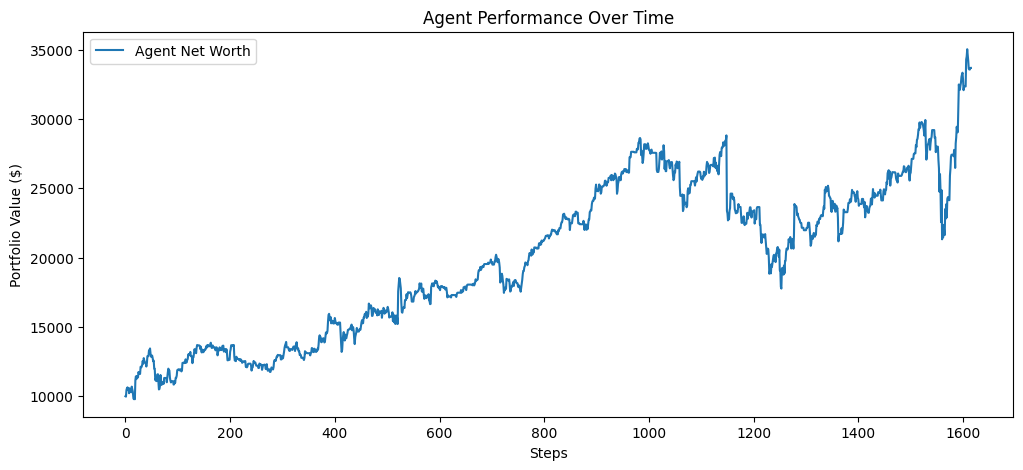

In [21]:
#Equity curve(net worth over time)
plt.figure(figsize=(12,5))
plt.plot(portfolio_values, label="Agent Net Worth")
plt.xlabel("Steps")
plt.ylabel("Portfolio Value ($)")
plt.title("Agent Performance Over Time")
plt.legend()
plt.show()

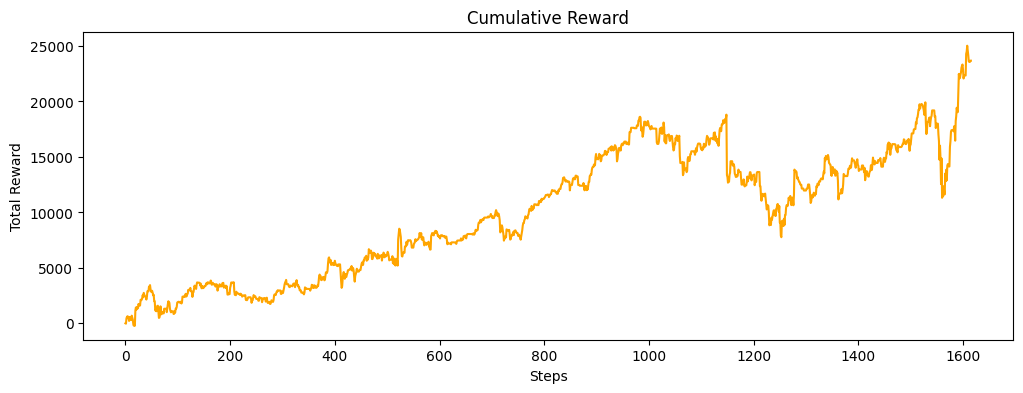

In [22]:
#Cumulative rewards
plt.figure(figsize=(12,4))
plt.plot(np.cumsum(rewards), color="orange")
plt.title("Cumulative Reward")
plt.xlabel("Steps")
plt.ylabel("Total Reward")
plt.show()

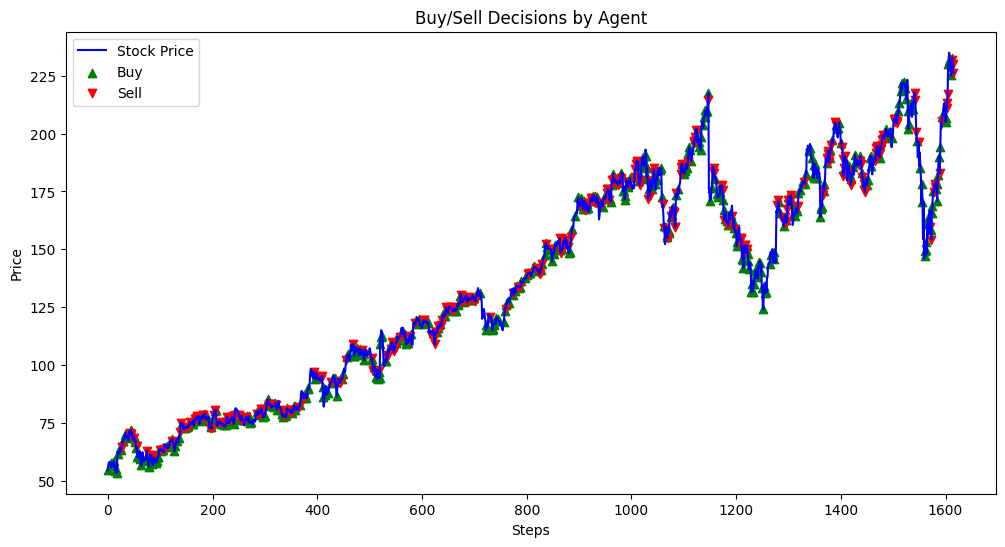

In [23]:
#Buy/sell visualization
plt.figure(figsize=(12,6))
plt.plot(prices, label="Stock Price", color="blue")
buy_steps = [i for i,a in enumerate(actions) if a == 1]
sell_steps = [i for i,a in enumerate(actions) if a == 2]
plt.scatter(buy_steps, [prices[i] for i in buy_steps], color="green", label="Buy", marker="^")
plt.scatter(sell_steps, [prices[i] for i in sell_steps], color="red", label="Sell", marker="v")
plt.legend()
plt.title("Buy/Sell Decisions by Agent")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.show()

In [24]:
#Compute metrics
returns = pd.Series(portfolio_values).pct_change().dropna()
sharpe = np.sqrt(252) * returns.mean() / returns.std()
total_return = (portfolio_values[-1] / portfolio_values[0]) - 1

print(f"📊 Total Return: {total_return*100:.2f}%")
print(f"⚖️ Sharpe Ratio: {sharpe:.2f}")

📊 Total Return: 236.80%
⚖️ Sharpe Ratio: 0.79
